<a href="https://colab.research.google.com/github/4nchez/keras/blob/master/Cats_vs_Dogs_(Kaggle)_CNN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats-vs-Dogs - Kaggle Challenge - Binary Image Classification using Keras
This workbook is my attempt to solve the [Kaggle Cats-vs-Dogs challenge](https://www.kaggle.com/c/dogs-vs-cats). <font color='firebrick'>. Here I create a CNN, which is improved using Image Augmentation and Transfer Learning techniques, specifically using the VGG16 model. **I use Keras on Tensorflow for my solution, which achieves 97% accuracy on the test dataset.**
 
It is recommended that you run this notebook on a GPU only, like ones available on Google Colab or Kaggle</font>
 
<center><img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg"></center>
 
#### <font color='firebrick'>NOTE: This notebook can work on Google Colab as well as offline with a small change</font>
* When running this notebook on Google Colab, please set `USE_COLAB=True` in cell below,  else set `USE_COLAB=False`.
* `USE_COLAB=True` will setup access to Google Drive for the current user's login (assuming she has a Google ID). 
    * Your Google Drive gets mapped to `/content/drive/My Drive`, and your Notebooks get saved to `/content/drive/My Drive/Colab Notebooks/` folder in your Google Drive. 
    * Code will add `/content/drive/My Drive/Colab Notebooks/` folder to `system.path`. Save your custom Python code files `(*.py)` here, so they are automatically added to `system.path` and you can use them in your notebook. * 
* A `MODEL_STATES` global var is created to point to the _correct_ folder where the model's state (i.e. trained weights & biases) is stored to an `.h5` file.
    * If `USE_COLAB=True`, `MODEL_STATES` maps to `/content/drive/My Drive/Colab Notebooks/model_states` folder on Google Drive.
    * Else, `MODEL_STATES` maps to `./model_states` folder on your local disk (i.e a sub-folder of folder where notebook is saved)

In [ ]:
!nvidia-sim

In [ ]:
!cat /proc/cpuinfo

In [ ]:
!cat /proc/meminfo

In [ ]:
from google.colab import files
src = list(files.upload().values())[0]

Saving kr_helper_funcs.py to kr_helper_funcs.py


In [ ]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True
 
import os
 
#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive
 
    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    colab_notebooks_path = os.path.join(grive_path, "Colab Notebooks/")
    
    if os.path.exists(colab_notebooks_path):
        print('You Colab notebooks are available at ', colab_notebooks_path)
    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'
 
        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        sys.path.append(colab_notebooks_path)
        print('NOTE: {} is appended to sys.path!'.format(colab_notebooks_path))
        # and test it
        # from content.drive.My Drive.Colab Notebooks.kr_helper_funcs import kr_helper_funcs as kru
        import kr_helper_funcs as kru
        MODEL_SAVE_DIR = "/content/drive/My Drive/Colab Notebooks/model_states"
        IMAGES_ZIP_DIR = "/content/drive/My Drive/Colab Notebooks/data/cats_vs_dogs"
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    IMAGES_ZIP_DIR = "./images/kaggle/cats_vs_dogs"
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
Your Google Drive is mounted at  /content/drive/My Drive/
You Colab notebooks are available at  /content/drive/My Drive/Colab Notebooks/
NOTE: /content/drive/My Drive/Colab Notebooks/ is appended to sys.path!


## About the Kaggle Dataset
The Kaggle training dataset archive (train.zip) contains 25,000 images of dogs and cats - 12,500 cat color images and 12,500 dog color images of various sizes. 

## Creating a smaller dataset
* Using a separate program, I created a smaller dataset on my laptop, comprising 5,000 training images _each_ for cats and dogs, 1,000 eval images _each_ for cats and dogs and 500 test images _each_ for cats and dogs. Then I uploaded a `zip` file of these images to my Google Drive.
* The zip file `cats_vs_dogs_images_small.zip` is available in the IMAGES_ZIP_DIR on my Google Drive. The code cell below downloads it locally and unzips the images to the `/tmp` folder.
* You will get `/tmp/images/cats_vs_dogs` folder, under which the training sets `train`, eval sets `eval` and `test` sets will be unzipped.

In [ ]:
import sys, os, random
import numpy as np
import tensorflow as tf
print('Using Tensorflow version ', tf.__version__)
import matplotlib.pyplot as plt
%matplotlib inline
 
import kr_helper_funcs as kru
 
plt.style.use('seaborn')
 
seed = 123
random.seed(seed)
np.random.seed(seed)
# tf.set_random_seed(seed)
 
import warnings
warnings.filterwarnings('ignore')  # ignore all warnings

Using Tensorflow version  2.3.0


In [ ]:
import os, shutil
import zipfile
 
#!cp $(IMAGES_ZIP_DIR/images_small.zip" /tmp
# NOTE: IMAGES_ZIP_DIR is set in the very first cell, where we connect to Google Drive
source_file = os.path.join(IMAGES_ZIP_DIR, 'cats_vs_dogs_images_small.zip')
local_zip = '/tmp/cats_vs_dogs_images_small.zip'
 
print("Copying from drive %s to %s..." % (source_file, local_zip), flush=True)
shutil.copyfile(source_file, local_zip)
 
assert os.path.exists(local_zip)
 
print('Extracting all images...', flush=True)
zip_ref = zipfile.ZipFile(local_zip, 'r')
 
zip_ref.extractall('/tmp')
zip_ref.close()

Copying from drive /content/drive/My Drive/Colab Notebooks/data/cats_vs_dogs/cats_vs_dogs_images_small.zip to /tmp/cats_vs_dogs_images_small.zip...
Extracting all images...


## 파일 이름 변경

In [77]:
!ls /tmp/test/cat|head

11500.jpg
11501.jpg
11502.jpg
11503.jpg
11504.jpg
11505.jpg
11506.jpg
11507.jpg
11508.jpg
11509.jpg


이미지 파일명을 '상위폴더.번호.jpg' 로 변경

In [82]:
# rename_file.py : 폴더 내의 파일을 불러와 이름 변경
# original 폴더 > (hood_T/long_T/...) 폴더 > hood_T_1.jpg 파일 있음.
# hood_T_1 (2).jpg -> hood_T_2.jpg와 같이 이름을 순서대로 변경
import os

folder_path = "/tmp/test/"                                # 폴더 이름에 따라 파일이름을 바꿀 것이므로 그 상위 폴더인 original을 path로 설정

folder_list = os.listdir(folder_path)                                               # 각 폴더 이름 (hood_T/hong_T/...)
#folder_list = ["hood_T", "long_T"]
for folder_name in folder_list :                                                    # 각 폴더 이름(hood_T)의 파일이름 얻기
    file_path = folder_path + "/" + folder_name                                    # file_path : D:\\python_D\\fashion_data\\original\\hood_T
    
    file_list = os.listdir(file_path)                                               # file_list[0] : D:\\python_D\\fashion_data\\original\\hood_T\\hood_T_1.jpg
    #file_list.sort()

    print("-------------------------------------------------")
    print(folder_name + " have " + str(len(file_list)) + " files.")
    print("file_path : " + file_path)
    
    # (hood_T_1(2).jpg -> 1.jpg) 이미 이름이 있는 파일이면 오류가 나기에 먼저 숫자로된 아무 이름으로 만들고, 다시 이름을 지정합니다.
    count = 1
    for file_name in file_list :
        old_name = file_path + "/" + file_name                                     # old_name = D:\\python_D\\fashion_data\\original\\hood_T\\hood_T_1 (2).jpg
        new_name = file_path + "/" + str(count) + ".jpg"                           # new_name = D:\\python_D\\fashion_data\\original\\hood_T\\1.jpg

        try:
            os.rename(old_name, new_name)
            print("success : " + file_name + " -> " + str(count) + ".jpg")
        except:
            print("fail : " + file_name + " -> " + str(count) + ".jpg")
            print("=========files already renamed original(abcde.jpg) to number(1.jpg)===========")
            
        count = count + 1


    # (1.jpg -> hood_T_1.jpg) : count 값을 다시 지정해 이름을 지정함.
    file_list = os.listdir(file_path)                                               # 1.jpg 로 바뀐 이름을 가져와야 되기 때문에 다시 로드
    count = 1
    for file_name in file_list :
        old_name = file_path + "/" + file_name                                     # old_name = 1.jpg
        new_name = file_path + "/" + folder_name + "." + str(count) + ".jpg"       # new_name = hood_T_1.jpg

        try:
            os.rename(old_name, new_name)
            print("success : " + file_name + " -> " + folder_name + "." + str(count) + ".jpg")
        except:
            print("fail : " + file_name + " -> " + folder_name + "." + str(count) + ".jpg")
            print("=========files already renamed number(1.jpg) to new_name(hood_T_1.jpg)===========")
            break
        count = count + 1

-------------------------------------------------
dog have 1000 files.
file_path : /tmp/test//dog
success : dog.166.jpg -> 1.jpg
success : dog.713.jpg -> 2.jpg
success : dog.89.jpg -> 3.jpg
success : dog.834.jpg -> 4.jpg
success : dog.107.jpg -> 5.jpg
success : dog.329.jpg -> 6.jpg
success : dog.668.jpg -> 7.jpg
success : dog.579.jpg -> 8.jpg
success : dog.507.jpg -> 9.jpg
success : dog.764.jpg -> 10.jpg
success : dog.282.jpg -> 11.jpg
success : dog.745.jpg -> 12.jpg
success : dog.203.jpg -> 13.jpg
success : dog.177.jpg -> 14.jpg
success : dog.284.jpg -> 15.jpg
success : dog.303.jpg -> 16.jpg
success : dog.257.jpg -> 17.jpg
success : dog.899.jpg -> 18.jpg
success : dog.299.jpg -> 19.jpg
success : dog.539.jpg -> 20.jpg
success : dog.255.jpg -> 21.jpg
success : dog.201.jpg -> 22.jpg
success : dog.341.jpg -> 23.jpg
success : dog.611.jpg -> 24.jpg
success : dog.316.jpg -> 25.jpg
success : dog.596.jpg -> 26.jpg
success : dog.130.jpg -> 27.jpg
success : dog.498.jpg -> 28.jpg
success : dog.23

In [86]:
!ls /tmp/test/cat|head
!ls /tmp/test/dog|head

cat.1000.jpg
cat.100.jpg
cat.101.jpg
cat.102.jpg
cat.103.jpg
cat.104.jpg
cat.105.jpg
cat.106.jpg
cat.107.jpg
cat.108.jpg
dog.1000.jpg
dog.100.jpg
dog.101.jpg
dog.102.jpg
dog.103.jpg
dog.104.jpg
dog.105.jpg
dog.106.jpg
dog.107.jpg
dog.108.jpg


In [ ]:
# all images have been un-zipped under this folder - I have 3 sub-folders for train, cross_val and test image sets
images_root = "/tmp" # /content/drive/My Drive/img
assert os.path.exists(images_root), "%s folder does not exist!" % images_root
 
train_root = os.path.join(images_root,'training')
train_root_cat = os.path.join(train_root,'cat')
train_root_dog = os.path.join(train_root,'dog')
 
eval_root = os.path.join(images_root,'validation')
eval_root_cat = os.path.join(eval_root,'cat')
eval_root_dog = os.path.join(eval_root,'dog')
 
test_root = os.path.join(images_root,'test')
test_root_cat = os.path.join(test_root,'cat')
test_root_dog = os.path.join(test_root,'dog')

In [ ]:
# Keras imports (Tensorflow's implementation of Keras)
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, MaxPooling2D, 
                                     Flatten, Dense, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kr_helper_funcs as kru

In [ ]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, BATCH_SIZE = 150, 150, 3, 32

## 간단한 CNN 모델 생성

In [ ]:
def build_model():
    from tensorflow.keras.optimizers import Adam
    
    # using Functional API
    K.clear_session()
    
    inp = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
 
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(inp)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
 
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.20)(x)
 
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.30)(x)
 
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='SAME')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.40)(x)
 
    x = Flatten()(x)
    x = Dropout(0.35)(x)
 
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.20)(x)
 
    out = Dense(1, activation='sigmoid')(x)
 
    model = Model(inputs=inp, outputs=out)
 
    opt = Adam(lr=0.0001, decay=1e-4)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])#accuracy
    return model

### Image Augmentation를 사용 하지 않은 실험


In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)
 
# flow from train root folders
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
eval_generator = eval_datagen.flow_from_directory(
    eval_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
model_cnn = build_model()
print(model_cnn.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)       

In [ ]:
# train model on generator
train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
train_steps, val_steps, test_steps

(312, 156, 62)

In [ ]:
# train model on generator
hist = model_cnn.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=100,
    validation_data=eval_generator,
    validation_steps=val_steps)

312/312 [==============================] - 51s 165ms/step - loss: 0.0085 - acc: 0.9975 - val_loss: 0.6446 - val_acc: 0.8538
Epoch 75/100
312/312 [==============================] - 51s 165ms/step - loss: 0.0102 - acc: 0.9973 - val_loss: 0.6769 - val_acc: 0.8397
Epoch 76/100
312/312 [==============================] - 52s 165ms/step - loss: 0.0091 - acc: 0.9978 - val_loss: 0.6275 - val_acc: 0.8552
Epoch 77/100
312/312 [==============================] - 51s 164ms/step - loss: 0.0102 - acc: 0.9971 - val_loss: 0.6360 - val_acc: 0.8602
Epoch 78/100
312/312 [==============================] - 50s 162ms/step - loss: 0.0086 - acc: 0.9983 - val_loss: 0.6017 - val_acc: 0.8630
Epoch 79/100
312/312 [==============================] - 50s 161ms/step - loss: 0.0061 - acc: 0.9988 - val_loss: 0.6417 - val_acc: 0.8534
Epoch 80/100
312/312 [==============================] - 50s 159ms/step - loss: 0.0096 - acc: 0.9976 - val_loss: 0.5952 - val_acc: 0.8554
Epoch 81/100
312/312 [==============================] 

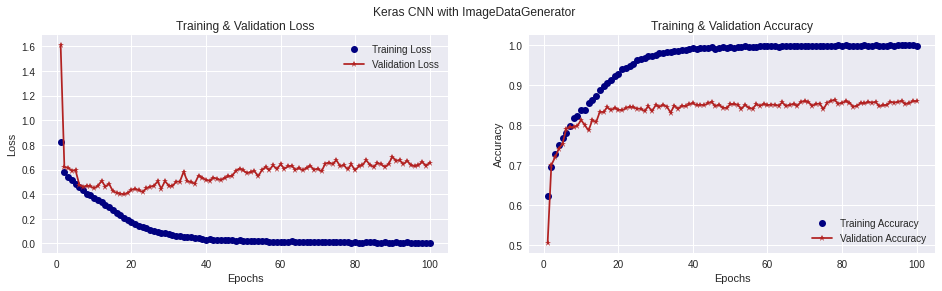

In [ ]:
kru.show_plots(hist.history, plot_title='Keras CNN with ImageDataGenerator')

In [ ]:
# evaluate performance on train & test data
loss, acc = model_cnn.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_cnn.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_cnn.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

Instructions for updating:
Please use Model.evaluate, which supports generators.
312/312 [==============================] - 30s 95ms/step - loss: 1.6018e-04 - acc: 1.0000
Training data  -> loss: 0.000, acc: 1.000
156/156 [==============================] - 15s 97ms/step - loss: 0.6557 - acc: 0.8594
Cross-val data -> loss: 0.656, acc: 0.859
62/62 [==============================] - 6s 94ms/step - loss: 0.7134 - acc: 0.8533
Testing data   -> loss: 0.713, acc: 0.853


#### 결과
 
>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|100%|85.9%|85.3%
 
* 훈련 정확도랑 검증 정확도를 비교해보면 약 15%의 차이를 갖는다. (과적합이 발생한 것으로 보임.)

In [ ]:
kru.save_keras_model(model_cnn, 'kr_cats_vs_dogs_base', MODEL_SAVE_DIR)
model_cnn.save('/content/drive/My Drive/Colab Notebooks/model_states/cat_vs_dog_base.h5')

Saved model to files /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_base.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_base.h5


### 테스트

In [ ]:
# now let's pick some random (10 each) images from the test sets and pass them through
# the classifier and see what we get
cat_test_files = np.array(os.listdir(test_root_cat))
dog_test_files = np.array(os.listdir(test_root_dog))
 
for _ in range(5):
    np.random.shuffle(cat_test_files)
    np.random.shuffle(dog_test_files)
 
test_image_files = []
for image in cat_test_files:
    test_image_files.append(os.path.join(test_root_cat, image))
for image in dog_test_files:
    test_image_files.append(os.path.join(test_root_dog, image))
test_image_files = np.array(test_image_files)
for _ in range(5): np.random.shuffle(test_image_files)
test_image_files[:10]

array(['/tmp/test/cat/12446.jpg', '/tmp/test/dog/11872.jpg',
       '/tmp/test/dog/11933.jpg', '/tmp/test/dog/11747.jpg',
       '/tmp/test/cat/11597.jpg', '/tmp/test/cat/12393.jpg',
       '/tmp/test/cat/11847.jpg', '/tmp/test/cat/12158.jpg',
       '/tmp/test/cat/11553.jpg', '/tmp/test/cat/11916.jpg'], dtype='<U23')

In [ ]:
# now let's run predictions
import numpy as np
from keras.preprocessing import image
 
for test_image in test_image_files[:20]:
    img = image.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images_list = np.vstack([x])
    classes = model_cnn.predict(images_list, batch_size=10)
    pred = classes[0]
    if pred >= 0.5:
        print('%*s - Prediction (%.4f) - is a DOG' % (50, test_image, classes[0]))
    else:
        print('%*s - Prediction (%.4f) - is a CAT' % (50, test_image, classes[0]))

                           /tmp/test/cat/12446.jpg - Prediction (0.0000) - is a CAT
                           /tmp/test/dog/11872.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/dog/11933.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/dog/11747.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/cat/11597.jpg - Prediction (0.0000) - is a CAT
                           /tmp/test/cat/12393.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/cat/11847.jpg - Prediction (0.0000) - is a CAT
                           /tmp/test/cat/12158.jpg - Prediction (0.0000) - is a CAT
                           /tmp/test/cat/11553.jpg - Prediction (0.0000) - is a CAT
                           /tmp/test/cat/11916.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/dog/11779.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/cat/11890.jpg - Prediction (1.0000) - i

In [ ]:
kru.save_keras_model(model_cnn, 'kr_cats_vs_dogs_noaug')
del model_cnn

Saved model to files ./keras_models/kr_cats_vs_dogs_noaug.json and ./keras_models/kr_cats_vs_dogs_noaug.h5


## Image Augmentation을 사용

모델 구조는 변경되지 않으며, 훈련에 사용할 이미지를 전처리해서 사용.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
 
# NOTE: no image aug for eval & test datagenerators
eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
# flow from train root folders
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
eval_generator = eval_datagen.flow_from_directory(
    eval_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
model_cnn = build_model()
print(model_cnn.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)       

In [ ]:
# train model on generator
train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
train_steps, val_steps, test_steps

(312, 156, 62)

In [ ]:
# train model on generator
hist = model_cnn.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=150,
    validation_data=eval_generator,
    validation_steps=val_steps)

312/312 [==============================] - 91s 291ms/step - loss: 0.3006 - acc: 0.8716 - val_loss: 0.2853 - val_acc: 0.8840
Epoch 122/150
312/312 [==============================] - 91s 291ms/step - loss: 0.2982 - acc: 0.8689 - val_loss: 0.3043 - val_acc: 0.8702
Epoch 123/150
312/312 [==============================] - 91s 292ms/step - loss: 0.2967 - acc: 0.8708 - val_loss: 0.2956 - val_acc: 0.8760
Epoch 124/150
312/312 [==============================] - 91s 292ms/step - loss: 0.3014 - acc: 0.8687 - val_loss: 0.2883 - val_acc: 0.8788
Epoch 125/150
312/312 [==============================] - 91s 292ms/step - loss: 0.2992 - acc: 0.8722 - val_loss: 0.2868 - val_acc: 0.8796
Epoch 126/150
312/312 [==============================] - 91s 291ms/step - loss: 0.3057 - acc: 0.8708 - val_loss: 0.3227 - val_acc: 0.8684
Epoch 127/150
312/312 [==============================] - 91s 292ms/step - loss: 0.2959 - acc: 0.8726 - val_loss: 0.3062 - val_acc: 0.8750
Epoch 128/150
312/312 [=========================

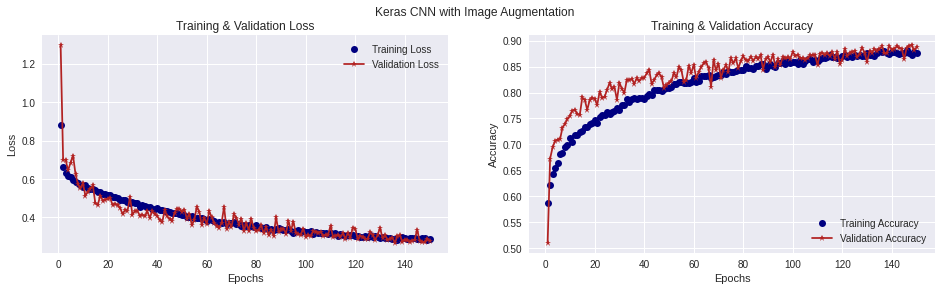

In [ ]:
kru.show_plots(hist.history, plot_title='Keras CNN with Image Augmentation')

In [ ]:
# evaluate performance on train & test data
loss, acc = model_cnn.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_cnn.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_cnn.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

312/312 [==============================] - 69s 222ms/step - loss: 0.2407 - acc: 0.8972
Training data  -> loss: 0.241, acc: 0.897
156/156 [==============================] - 15s 95ms/step - loss: 0.2776 - acc: 0.8874
Cross-val data -> loss: 0.278, acc: 0.887
62/62 [==============================] - 6s 93ms/step - loss: 0.2386 - acc: 0.8987
Testing data   -> loss: 0.239, acc: 0.899


### Image Augmentation 사용 결과

>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|100%|85.9%|85.3%
>**With Image Aug**|89.7%|88.7%|89.9%

* 과적합 부분이 약 15%에서 1%로 크게 감소 하였다.
* 또한 이전 실험보다 정확도가 4% 넘게 성장하였다.

결론적으로, **Image Augmentation을 사용하면 같은 모델이 더라도 성능을 향상 시킬수 있었다.**.


### 테스트

In [ ]:
# now let's pick some random (10 each) images from the test sets and pass them through
# the classifier and see what we get
cat_test_files = np.array(os.listdir(test_root_cat))
dog_test_files = np.array(os.listdir(test_root_dog))
# for _ in range(5): indexes = np.random.permutation(range(len(cat_test_files)))
# cat_test_files = cat_test_files[indexes]
# dog_test_files = dog_test_files[indexes]
for _ in range(5):
    np.random.shuffle(cat_test_files)
    np.random.shuffle(dog_test_files)
 
test_image_files = []
for image in cat_test_files:
    test_image_files.append(os.path.join(test_root_cat, image))
for image in dog_test_files:
    test_image_files.append(os.path.join(test_root_dog, image))
test_image_files = np.array(test_image_files)
for _ in range(5): indexes = np.random.permutation(range(len(test_image_files)))
test_image_files = test_image_files[indexes]
test_image_files[:10]

array(['/tmp/test/dog/12049.jpg', '/tmp/test/cat/11843.jpg',
       '/tmp/test/cat/11691.jpg', '/tmp/test/dog/11779.jpg',
       '/tmp/test/dog/11616.jpg', '/tmp/test/dog/12181.jpg',
       '/tmp/test/cat/11882.jpg', '/tmp/test/cat/12497.jpg',
       '/tmp/test/cat/11508.jpg', '/tmp/test/dog/11519.jpg'], dtype='<U23')

In [ ]:
# now let's run predictions
import numpy as np
from keras.preprocessing import image
dog, cat = 0, 0
for test_image in test_image_files:
    img = image.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images_list = np.vstack([x])
    classes = model_cnn.predict(images_list, batch_size=10)
    pred = classes[0]
    if pred >= 0.5:
        dog+=1
        print('%*s - Prediction (%.4f) - is a DOG' % (50, test_image, classes[0]))
    else:
        cat+=1
        print('%*s - Prediction (%.4f) - is a CAT' % (50, test_image, classes[0]))
print("dog : ",dog)
print("cat : ",cat)

                           /tmp/test/dog/12049.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/cat/11843.jpg - Prediction (0.0000) - is a CAT
                           /tmp/test/cat/11691.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/dog/11779.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/dog/11616.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/dog/12181.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/cat/11882.jpg - Prediction (0.0000) - is a CAT
                           /tmp/test/cat/12497.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/cat/11508.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/dog/11519.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/cat/12292.jpg - Prediction (1.0000) - is a DOG
                           /tmp/test/cat/11837.jpg - Prediction (1.0000) - i

In [ ]:
 # now let's run predictions
import numpy as np
from keras.preprocessing import image
 
predictions = []   # list of tuples (image_path, probab, pred_name, act_name)
incorrect_predictions = []  # list of tuples (image_path, probab, actual, prediction)
 
for test_image in test_image_files:
    img = image.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0
 
    images_list = np.vstack([x])
    classes = model_cnn.predict(images_list, batch_size=10)
    prob = classes[0]
    actual_name = (test_image.split(os.path.sep)[-1].split('.')[0]).upper() # == 'CAT' or 'DOG'
    pred_name = 'DOG' if (prob >= 0.5) else 'CAT'
    is_correct = (actual_name == pred_name)
    
    predictions.append((test_image, prob, pred_name, actual_name))
    if not is_correct:
        incorrect_predictions.append((test_image, prob, pred_name, actual_name))
    
    
print("Displaying %d incorrect predictions..." % len(incorrect_predictions))    
for item in incorrect_predictions:
    test_image, prob, pred_name, actual_name = item
    print('%*s - probability: %.4f - predicted %s, is a %s' %
            (50, test_image, prob, pred_name, actual_name))
 
# print("Displaying first 50 predictions...")    
# for item in predictions[:50]:
#     test_image, prob, pred_name, actual_name = item
#     oops = ' -- Oops!' if pred_name != actual_name else ''
#     print('%*s - Prediction (%.4f): is a DOG %s' % (50, test_image, classes[0], oops))
    
#     if pred >= 0.5:
#         print('%*s - Prediction (%.4f): is a DOG %s' % (50, test_image, classes[0], oops))
#     else:
#         print('%*s - Prediction (%.4f): is a CAT %s' % (50, test_image, classes[0], oops))

In [ ]:
kru.save_keras_model(model_cnn, 'kr_cats_vs_dogs_aug')
#del model_cnn
model_cnn.save('/content/drive/My Drive/Colab Notebooks/model_states/cat_vs_dog_aug.h5')

Saved model to files ./keras_models/kr_cats_vs_dogs_aug.json and ./keras_models/kr_cats_vs_dogs_aug.h5


## 전이 학습 with VGG모델


Keras에선 ImageNet대회에서 사용한 여러 모델들(Xception, VGG16, VGG 제공합니다. [참고](https://keras.io/applications/)
이 중에서 VGG 16 모델을 사용합니다.

## VGG16모델

VGG(Visual Geometry Group)Net은 옥스퍼드 대학의 연구팀 VGG에 의해 개발된 모델로써, 2014년 이미지넷 이미지 인식 대회에서 준우승을 한 모델이다. 여기서 말하는 VGGNet은 16개 또는 19개의 층으로 구성된 모델을 의미한다(VGG16, VGG19로 불림).
AlexNet과 유사하지만, 병렬구조로 이루어져 있지 않다. [논문](https://arxiv.org/pdf/1409.1556.pdf%20http://arxiv.org/abs/1409.1556.pdf)

*   깊이에 따른 실험결과를 나타냄.
*   깊은 구조를 만들기 위해 가장 작은 커널 사이즈인 3x3을 사용함.
*   깊이가 깊을 수록 성능이 좋음.
*   그러나 모델의 밑단인 FC(fully connected layer)가 존재하여 많은 파라미터를 사용함. 
*   또한, VGG16과 VGG19의 차이가 크지 않다. (즉 깊이가 무조건 깊다고 성능이 좋은 것은 아님.)


VGG16 구조
![image.png](https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network.jpg)
![image.png](https://neurohive.io/wp-content/uploads/2018/11/vgg16.png)
[논문](https://arxiv.org/pdf/1409.1556.pdf%20http://arxiv.org/abs/1409.1556.pdf)에서 실험한 모델구조
![image.png](https://neurohive.io/wp-content/uploads/2018/11/Capture-564x570.jpg)
이미지 출처 https://neurohive.io/en/popular-networks/vgg16/


### ㅁㅁㅁ

The first step is to create an instance of the model, which will download weights for ImageNet. Following is the code to instantiate the model.

Note that we use `include_top=False`. This is to drop _all_ the Dense layers of the pre-trained VGG16 mode and keep just the Conv2d base. In doing so, we have _kept_ the section of the model that learns the various patterns within images (i.e. the Convnets), but have discarded the _prediction_ layers (Dense layers), which we will replace with our own layers. The _convnets_ have already learns various abstract patterns - this learning can be re-applied to other problems. By replacing the Dense layers, we will be tweaking the model for our images set.


In [ ]:
from tensorflow.keras.applications import VGG16
 
# NOTE: will download the weights for imagenet
vgg_base = VGG16(weights='imagenet',    # use weights for ImageNet
                 include_top=False,     # don't use upper Dense layers
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
print(vgg_base.summary())

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

Here is the model we use - note that any model can be used as a layer in any other model. We have used `vgg_base` as the first layer of our model. After this layer come our custom `Flatten` and `Dense` layers - we use 2 `Dense` layers with 1024 and 512 nodes respectively. We also add some `Dropout` layers in between.

Since we want to re-use the pre-trained weights & biases on the `vgg_base` model, we will need _tell_ Keras not to update weights while training. The way to do so is to set the `trainable` attribute to `False`. 

Next we compile our model as usual - we use the `Adam` optimizer, a `binary_crossentropy` loss (as this is a binary classification problem) and ask Keras to track `accuracy` metrics as it trained our model.

In [ ]:
def build_model_xfer():
    from tensorflow.keras.optimizers import Adam
    
    #tf.keras.backend.clear_session()  # reset graph etc.
    
    model = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg_base,
        # here is our custom prediction layer (same as before)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
    
    # mark vgg_base as non-trainable, so training updates
    # weights and biases of just our newly added layers
    vgg_base.trainable = False
    
    model.compile(optimizer=Adam(lr=1e-4), 
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

In [ ]:
model_xfer = build_model_xfer()
print(model_xfer.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0

**Notice that our model has 23,629,633 parameters, but _only_ 8,914,945 are _trainable_. We have _frozen_ 14,714,688 parameters of the `vgg_base` model by setting `trainable=False`. The trainable paramaters come from our Dense layers which we slapped on on top of the `vgg_base` model**

Let's **train** this model **with image augmentation for 50 epochs** - since we have _frozen_ `vgg_base`, this is training just the `Dense` layers we added atop `vgg_base`

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
 
# NOTE: no image aug for eval & test datagenerators
eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
# flow from train root folders
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
eval_generator = eval_datagen.flow_from_directory(
    eval_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
# train model on generator
train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
train_steps, val_steps, test_steps

(312, 156, 62)

In [ ]:
# training our 'huge' model
# WARNING: this should be run ONLY on GPU, like Google Colab
hist = model_xfer.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

Epoch 1/50
312/312 [==============================] - 94s 302ms/step - loss: 0.4924 - acc: 0.7565 - val_loss: 0.2933 - val_acc: 0.8712
Epoch 2/50
312/312 [==============================] - 93s 297ms/step - loss: 0.4146 - acc: 0.8082 - val_loss: 0.2882 - val_acc: 0.8706
Epoch 3/50
312/312 [==============================] - 92s 296ms/step - loss: 0.3893 - acc: 0.8176 - val_loss: 0.2657 - val_acc: 0.8844
Epoch 4/50
312/312 [==============================] - 92s 296ms/step - loss: 0.3807 - acc: 0.8244 - val_loss: 0.2479 - val_acc: 0.8972
Epoch 5/50
312/312 [==============================] - 94s 301ms/step - loss: 0.3733 - acc: 0.8272 - val_loss: 0.2541 - val_acc: 0.8876
Epoch 6/50
312/312 [==============================] - 93s 298ms/step - loss: 0.3711 - acc: 0.8295 - val_loss: 0.2656 - val_acc: 0.8842
Epoch 7/50
312/312 [==============================] - 93s 297ms/step - loss: 0.3633 - acc: 0.8326 - val_loss: 0.2446 - val_acc: 0.8970
Epoch 8/50
312/312 [==============================] - 9

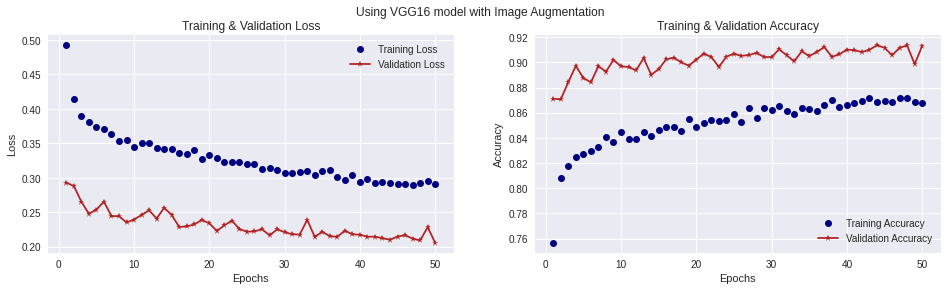

In [ ]:
kru.show_plots(hist.history, plot_title='Using VGG16 model with Image Augmentation')

In [ ]:
# evaluate performance on train & test data
loss, acc = model_xfer.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

312/312 [==============================] - 77s 246ms/step - loss: 0.2460 - acc: 0.8921
Training data  -> loss: 0.246, acc: 0.892
156/156 [==============================] - 16s 103ms/step - loss: 0.2058 - acc: 0.9129
Cross-val data -> loss: 0.206, acc: 0.913
62/62 [==============================] - 6s 103ms/step - loss: 0.1978 - acc: 0.9209
Testing data   -> loss: 0.198, acc: 0.921


>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Pre-trained VGG16**|89.2%|91.3%|92.1%

### Observations with Pretrained Model:

>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|100%|85.9%|85.3%
>**With Image Aug**|89.7%|88.7%|89.9%
>**Pre-trained VGG16**|89.2%|91.3%|92.1%


* Using a pre-trained model like VGG16, has increased the cross-val & test accuracies further - we can see a 2-3% improvement in the test accuracy alone!

Next let's  evaluate performance of our pre-trained model.

In [93]:
# Save model state to my Google Drive
kru.save_keras_model(model_xfer, 'kr_cats_vs_dogs_pretrained_vgg16', MODEL_SAVE_DIR)
model_xfer.save('/content/drive/My Drive/Colab Notebooks/model_states/cat_vs_dog_pretrained_vgg16.h5')
del model_xfer

Saved model to files /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16.h5


In [94]:
model_xfer = kru.load_keras_model('kr_cats_vs_dogs_pretrained_vgg16',MODEL_SAVE_DIR)
print(model_xfer.summary())

Loaded model from files /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16.h5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
______________________________________________

In [95]:
# now let's pick some random (10 each) images from the test sets and pass them through
# the classifier and see what we get
cat_test_files = np.array(os.listdir(test_root_cat))
dog_test_files = np.array(os.listdir(test_root_dog))
# for _ in range(5): indexes = np.random.permutation(range(len(cat_test_files)))
# cat_test_files = cat_test_files[indexes]
# dog_test_files = dog_test_files[indexes]
for _ in range(5):
    np.random.shuffle(cat_test_files)
    np.random.shuffle(dog_test_files)
 
test_image_files = []
for image in cat_test_files:
    test_image_files.append(os.path.join(test_root_cat, image))
for image in dog_test_files:
    test_image_files.append(os.path.join(test_root_dog, image))
test_image_files = np.array(test_image_files)
for _ in range(5): indexes = np.random.permutation(range(len(test_image_files)))
test_image_files = test_image_files[indexes]
test_image_files[:10]

array(['/tmp/test/dog/dog.812.jpg', '/tmp/test/cat/cat.864.jpg',
       '/tmp/test/dog/dog.551.jpg', '/tmp/test/dog/dog.746.jpg',
       '/tmp/test/dog/dog.97.jpg', '/tmp/test/cat/cat.940.jpg',
       '/tmp/test/dog/dog.68.jpg', '/tmp/test/cat/cat.341.jpg',
       '/tmp/test/dog/dog.876.jpg', '/tmp/test/cat/cat.532.jpg'],
      dtype='<U26')

In [96]:
# now let's run predictions
import numpy as np
from keras.preprocessing import image
from tqdm import tqdm
predictions = []   # list of tuples (image_path, probab, pred_name, act_name)
incorrect_predictions = []  # list of tuples (image_path, probab, actual, prediction)
 
for test_image in tqdm(test_image_files):
    img = image.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0
 
    images_list = np.vstack([x])
    classes = model_xfer.predict(images_list, batch_size=10)
    prob = classes[0]
    actual_name = (test_image.split(os.path.sep)[-1].split('.')[0]).upper() # == 'CAT' or 'DOG'
    pred_name = 'DOG' if (prob >= 0.5) else 'CAT'
    is_correct = (actual_name == pred_name)
    
    predictions.append((test_image, prob, pred_name, actual_name))
    if not is_correct:
        incorrect_predictions.append((test_image, prob, pred_name, actual_name))
    
    
print("Displaying %d incorrect predictions..." % len(incorrect_predictions))    
for item in incorrect_predictions:
    test_image, prob, pred_name, actual_name = item
    print('%*s - probability: %.4f - predicted %s, is a %s' %
            (50, test_image, prob, pred_name, actual_name))
 
# print("Displaying first 50 predictions...")    
# for item in predictions[:50]:
#     test_image, prob, pred_name, actual_name = item
#     oops = ' -- Oops!' if pred_name != actual_name else ''
#     print('%*s - Prediction (%.4f): is a DOG %s' % (50, test_image, classes[0], oops))
    
#     if pred >= 0.5:
#         print('%*s - Prediction (%.4f): is a DOG %s' % (50, test_image, classes[0], oops))
#     else:
#         print('%*s - Prediction (%.4f): is a CAT %s' % (50, test_image, classes[0], oops))

100%|██████████| 2000/2000 [01:22<00:00, 24.33it/s]

Displaying 159 incorrect predictions...
                         /tmp/test/cat/cat.940.jpg - probability: 0.7232 - predicted DOG, is a CAT
                         /tmp/test/cat/cat.502.jpg - probability: 0.8414 - predicted DOG, is a CAT
                         /tmp/test/dog/dog.700.jpg - probability: 0.2741 - predicted CAT, is a DOG
                         /tmp/test/cat/cat.988.jpg - probability: 0.6337 - predicted DOG, is a CAT
                         /tmp/test/dog/dog.987.jpg - probability: 0.2762 - predicted CAT, is a DOG
                         /tmp/test/dog/dog.774.jpg - probability: 0.4970 - predicted CAT, is a DOG
                         /tmp/test/cat/cat.665.jpg - probability: 0.9593 - predicted DOG, is a CAT
                         /tmp/test/cat/cat.876.jpg - probability: 0.7410 - predicted DOG, is a CAT
                         /tmp/test/cat/cat.407.jpg - probability: 0.7458 - predicted DOG, is a CAT
                         /tmp/test/cat/cat.995.jpg - probability: 0.8

**Let's check on the `Oops!` results**

In [ ]:
def show_image(entry):
    import numpy as np
    from keras.preprocessing import image
    import matplotlib.pyplot as plt
    
    test_image, prob, pred_name, actual_name = entry
    
    img = image.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    img_arr /= 255.
    plt.imshow(img_arr[0])
    #plt.title('%s -> Prediction: %s (%.4f)' % (actual_name, pred_name, prob))
    plt.show()

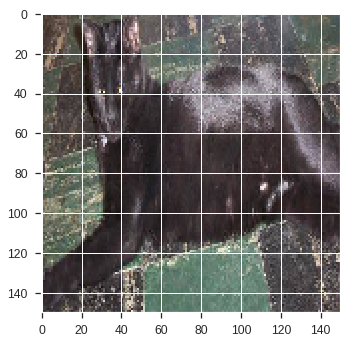

In [ ]:
show_image(incorrect_predictions[5])

## Transfer Learning - Finetuning

The technique we used above is called the **Feature Extraction** technique. Here we locked all the _Convolutional layers_ (which are essentially layers where the model learns all the intricate features of the images) and slapped our own _Dense_ layers atop. The Dense layers generate predictions off the patterns learnt by the convolutional base. By replacing these layers with our own Dense layers, we _repurposed_ it for our classification problem.

We can further improve the performance of the model using **Fine Tuning**. In this technique, we look at 'unlocking' one or move of the `upper` Conv2d layers of `vgg_base` and stack our custom dense layer on top of it. This way the last few Conv2d layers also learn specific features of our cat & dog images. 

**Why just the upper Conv2d layers?** Because the lower layers have learnt the more course features and the upper layers keep learning finer patterns, so it makes sense to tune the finer patterns of the Conv2d section for our problem of classifying just cats or dogs.

In [ ]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
# now let's unlock a few of teh higher Conv2d layers - say from block5_conv2 
# (i.e. block5_conv2, block5_conv3 and block5_pool, though the pooling layer has no trainable params!)
 
trainable = False
 
for layer in vgg_base.layers:
    if layer.name == 'block5_conv2':
        trainable = True
    # will set to False until we hit the "block5_conv2" layer    
    layer.trainable = trainable
    
print(vgg_base.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Notice that some of the 14,714,688 parameters of `vgg_base` have now become _trainable_!

Now let's build our model - the structure is exactly the same as before, but we _omit_ the step where we froze `vgg_base` entirely.

In [ ]:
# now let's build our model
def build_model_xfer2():
    from tensorflow.keras.optimizers import Adam
    
    #tf.keras.backend.clear_session()  # reset graph etc.
    
    model = tf.keras.models.Sequential([
        # our vgg16_base model added as a layer
        vgg_base,
        # here is our custom prediction layer (same as before)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.20),        
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.10),         
        tf.keras.layers.Dense(1, activation='sigmoid')    
    ])
    
    # NOTE: we do not freeze vgg_base entirely as done previously!!
    
    model.compile(optimizer=Adam(lr=1e-4), 
                  loss='binary_crossentropy',
                  metrics=['acc'])
    return model

In [ ]:
model_xfer2 = build_model_xfer2()
print(model_xfer2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)              

Let's train our model the usual way, using Image Augmentation - this is the same code as before. I am reproducing the above cells below.

<font color='scarlet'>**WARNING:** Run this on a capable GPU only! (e.g. Google Colab)</font>

In [108]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
 
# NOTE: no image aug for eval & test datagenerators
eval_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [109]:
# flow from train root folders
train_generator = train_datagen.flow_from_directory(
    train_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
eval_generator = eval_datagen.flow_from_directory(
    eval_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')
 
test_generator = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),  # all images will be resizes to this size
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [110]:
# train model on generator
train_steps = train_generator.n // BATCH_SIZE
val_steps = eval_generator.n // BATCH_SIZE
test_steps = test_generator.n // BATCH_SIZE
train_steps, val_steps, test_steps

(312, 156, 62)

In [ ]:
# training our 'huge' model
# WARNING: this should be run ONLY on GPU, like Google Colab
hist = model_xfer2.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=eval_generator,
    validation_steps=val_steps)

Epoch 1/50
312/312 [==============================] - 93s 297ms/step - loss: 0.0714 - acc: 0.9745 - val_loss: 0.2173 - val_acc: 0.9445
Epoch 2/50
312/312 [==============================] - 92s 295ms/step - loss: 0.0499 - acc: 0.9814 - val_loss: 0.2317 - val_acc: 0.9433
Epoch 3/50
312/312 [==============================] - 92s 296ms/step - loss: 0.0517 - acc: 0.9801 - val_loss: 0.2288 - val_acc: 0.9461
Epoch 4/50
312/312 [==============================] - 92s 296ms/step - loss: 0.0482 - acc: 0.9819 - val_loss: 0.2732 - val_acc: 0.9407
Epoch 5/50
312/312 [==============================] - 92s 295ms/step - loss: 0.0480 - acc: 0.9824 - val_loss: 0.2263 - val_acc: 0.9473
Epoch 6/50
312/312 [==============================] - 92s 296ms/step - loss: 0.0445 - acc: 0.9840 - val_loss: 0.2281 - val_acc: 0.9465
Epoch 7/50
312/312 [==============================] - 92s 293ms/step - loss: 0.0408 - acc: 0.9854 - val_loss: 0.2577 - val_acc: 0.9465
Epoch 8/50
312/312 [==============================] - 9

In [102]:
kru.show_plots(hist.history, plot_title='Using Fine Tunes VGG16 model with Image Augmentation')

In [106]:
# evaluate performance on train & test data
loss, acc = model_xfer2.evaluate_generator(train_generator, steps=train_steps, verbose=1)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer2.evaluate_generator(eval_generator, steps=val_steps, verbose=1)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model_xfer2.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

RuntimeError: ignored

### Observations with Fine Tuned Pretrained Model:

>Configuration | Training Acc | Cross-val Acc | Test Acc 
>:---|:---:|:---:|:---:|
>**Base Model**|100%|85.9%|85.3%
>**With Image Aug**|89.7%|88.7%|89.9%
>**Pre-trained VGG16**|89.2%|91.3%|92.1%
>**Fine-tuned VGG16**|98-99%|95-96%|96-97%

* Wow! I am now getting ~97% test accuracy using this method.

In [ ]:
# Save model state to my Google Drive
kru.save_keras_model(model_xfer2, 'kr_cats_vs_dogs_pretrained_vgg16_ft', MODEL_SAVE_DIR)
model_xfer2.save('/content/drive/My Drive/Colab Notebooks/model_stacat_vs_dog_basevgg16.h5')
del model_xfer2

Saved model to files /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16_ft.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16_ft.h5


In [ ]:
model_xfer2 = kru.load_keras_model('kr_cats_vs_dogs_pretrained_vgg16_ft',MODEL_SAVE_DIR)
print(model_xfer2.summary())

Loaded model from files /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16_ft.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16_ft.h5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
______________________________________

In [100]:
# now let's pick some random (10 each) images from the test sets and pass them through
# the classifier and see what we get
cat_test_files = np.array(os.listdir(test_root_cat))
dog_test_files = np.array(os.listdir(test_root_dog))
# for _ in range(5): indexes = np.random.permutation(range(len(cat_test_files)))
# cat_test_files = cat_test_files[indexes]
# dog_test_files = dog_test_files[indexes]
for _ in range(5):
    np.random.shuffle(cat_test_files)
    np.random.shuffle(dog_test_files)
 
test_image_files = []
for image in cat_test_files:
    test_image_files.append(os.path.join(test_root_cat, image))
for image in dog_test_files:
    test_image_files.append(os.path.join(test_root_dog, image))
test_image_files = np.array(test_image_files)
for _ in range(5): indexes = np.random.permutation(range(len(test_image_files)))
test_image_files = test_image_files[indexes]
test_image_files[:10]

array(['/tmp/test/cat/cat.660.jpg', '/tmp/test/dog/dog.817.jpg',
       '/tmp/test/cat/cat.581.jpg', '/tmp/test/dog/dog.246.jpg',
       '/tmp/test/cat/cat.677.jpg', '/tmp/test/dog/dog.875.jpg',
       '/tmp/test/cat/cat.754.jpg', '/tmp/test/cat/cat.600.jpg',
       '/tmp/test/dog/dog.442.jpg', '/tmp/test/dog/dog.462.jpg'],
      dtype='<U26')

In [101]:
# now let's run predictions
import numpy as np
from keras.preprocessing import image
from tqdm import tqdm

predictions = []   # list of tuples (image_path, probab, pred_name, act_name)
incorrect_predictions = []  # list of tuples (image_path, probab, actual, prediction)

for test_image in tqdm(test_image_files):
    img = image.load_img(test_image, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0

    images_list = np.vstack([x])
    classes = model_xfer2.predict(images_list, batch_size=10)
    prob = classes[0]
    actual_name = (test_image.split(os.path.sep)[-1].split('.')[0]).upper() # == 'CAT' or 'DOG'
    pred_name = 'DOG' if (prob >= 0.5) else 'CAT'
    is_correct = (actual_name == pred_name)
    
    predictions.append((test_image, prob, pred_name, actual_name))
    if not is_correct:
        incorrect_predictions.append((test_image, prob, pred_name, actual_name))
    
    
print("Displaying %d incorrect predictions..." % len(incorrect_predictions))    
for item in incorrect_predictions:
    test_image, prob, pred_name, actual_name = item
    print('%*s - probability: %.4f - predicted %s, is a %s' %
            (50, test_image, prob, pred_name, actual_name))

# print("Displaying first 50 predictions...")    
# for item in predictions[:50]:
#     test_image, prob, pred_name, actual_name = item
#     oops = ' -- Oops!' if pred_name != actual_name else ''
#     print('%*s - Prediction (%.4f): is a DOG %s' % (50, test_image, classes[0], oops))
    
#     if pred >= 0.5:
#         print('%*s - Prediction (%.4f): is a DOG %s' % (50, test_image, classes[0], oops))
#     else:
#         print('%*s - Prediction (%.4f): is a CAT %s' % (50, test_image, classes[0], oops))

100%|██████████| 2000/2000 [01:23<00:00, 23.89it/s]

Displaying 92 incorrect predictions...
                         /tmp/test/cat/cat.988.jpg - probability: 0.6118 - predicted DOG, is a CAT
                         /tmp/test/dog/dog.701.jpg - probability: 0.0013 - predicted CAT, is a DOG
                         /tmp/test/cat/cat.777.jpg - probability: 0.9730 - predicted DOG, is a CAT
                         /tmp/test/dog/dog.735.jpg - probability: 0.1735 - predicted CAT, is a DOG
                         /tmp/test/cat/cat.436.jpg - probability: 0.9999 - predicted DOG, is a CAT
                         /tmp/test/cat/cat.714.jpg - probability: 0.9705 - predicted DOG, is a CAT
                         /tmp/test/cat/cat.713.jpg - probability: 0.8447 - predicted DOG, is a CAT
                         /tmp/test/dog/dog.706.jpg - probability: 0.1977 - predicted CAT, is a DOG
                         /tmp/test/cat/cat.181.jpg - probability: 0.9967 - predicted DOG, is a CAT
                         /tmp/test/cat/cat.651.jpg - probability: 1.00

## 새로운 이미지 파일 업로드 및 테스트

In [69]:
#업로드 위치 : /content/
from google.colab import files
src = list(files.upload().values())[0]

Saving KakaoTalk_20200814_094123441.jpg to KakaoTalk_20200814_094123441.jpg


In [43]:
#위의 모델 중 성능이 가장 좋은 모델을 불러옴.
model = kru.load_keras_model('kr_cats_vs_dogs_pretrained_vgg16_ft',MODEL_SAVE_DIR)
print(model.summary())

Loaded model from files /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16_ft.json and /content/drive/My Drive/Colab Notebooks/model_states/kr_cats_vs_dogs_pretrained_vgg16_ft.h5
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
______________________________________

In [61]:
#분류 작업
classes = { 
    0.0:'its a cat',
    1.0:'its a dog',
}
def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    # image = image.load_img(image, target_size=(IMG, IMG))
    image = image.resize((IMG,IMG))
    # image = image.img_to_array(img)
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    image = image/255
    pred = model.predict([image])[0]
    if pred >= 0.5: sign = classes[1.0]
    else: sign = classes[0.0]
    # sign = pred[0]
    print(sign)

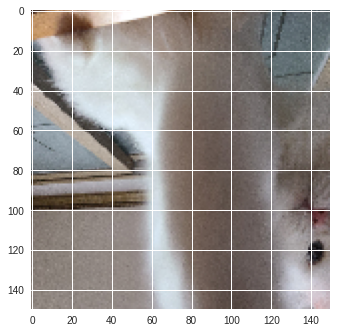

In [72]:
#결과 
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

# test_image, prob, pred_name, actual_name = entry

img = image.load_img('kakao1.jpg', target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr /= 255.
plt.imshow(img_arr[0])
#plt.title('%s -> Prediction: %s (%.4f)' % (actual_name, pred_name, prob))
plt.show()

In [73]:
classify('kakao1.jpg')

its a cat
